In [1]:
import uproot

def create_df(tree_path, branches = None):
    # tree_path: string, path to file that should include the TDirectories/TTree names: 
    # branches: array of strings, such as ["run","subrun","event"]
    
    # example: tree.root:TDirectory/TTree
    tree = uproot.open(tree_path)
    if branches == None:
        df = tree.arrays(library="pd")
    else:
        df = tree.arrays(branches, library="pd")
    return df

def create_truth_df(tree_path):
    # input should be the path to a **flat.caf.root:recTree** 
    branches = ['rec.hdr.run','rec.hdr.subrun','rec.hdr.evt',
                'rec.mc.nnu','rec.mc.nu.pdg','rec.mc.nu.iscc','rec.mc.nu.isnc',
                'rec.mc.nu.time','rec.mc.nu.E','rec.mc.nu.index',
                'rec.mc.nu.position.x','rec.mc.nu.position.y','rec.mc.nu.position.z']
    df = create_df(tree_path, branches)
    df.columns = ['run','subrun','event',"nnu","pdg",'iscc','isnc','time','truE','nu_index','vtx_x','vtx_y','vtx_z']
    return df

def create_slice_df(tree_path):
    # input should be the path to a **flat.caf.root:recTree** 
    branches  = ['rec.hdr.run','rec.hdr.subrun','rec.hdr.evt',
                 'rec.slc.self',"rec.slc.nu_score","rec.slc.fmatch.score","rec.slc.crumbs_result.score",
                 'rec.slc.truth.index','rec.slc.tmatch.eff','rec.slc.tmatch.pur', 
                 'rec.slc.vertex.x','rec.slc.vertex.y','rec.slc.vertex.z',
                 'rec.slc.charge',
                 ]
    df = create_df(tree_path, branches)
    df.columns = ['run','subrun','event','pfpid','nscore',"fscore","crumbs_score",'nu_index','eff','pur',"rec_vtx_x","rec_vtx_y","rec_vtx_z","rec_charge"]
    return df

In [2]:
import matplotlib.pyplot as plt 
import matplotlib as mpl
import numpy as np
import pandas as pd

In [3]:
def create_match_df(opt0_path,stop=None):
    # opt0_path: should be a string, path to opt0 file 
    # stop (int): how many entries to stop when also obtaining the flash/hypo spectrum 
    match_tree = uproot.open(opt0_path+":fixopt0finder/flash_match_tree")
    if stop==None: 
        match_df = match_tree.arrays(['run','subrun','event','tpc','pfpid','matchid','score','t0','hypo_pe','flash_pe'],library='pd') 
    else:
        match_df = match_tree.arrays(library='pd',entry_stop=stop)
        match_df.rename(columns={"subentry" : "pdch"},inplace=True)
        # match_df = match_df[((match_df.hypo_spec==0) & (match_df.flash_spec==0))==False]
    match_df["hypo_frac_diff"] = (match_df["hypo_pe"]-match_df["flash_pe"])/(match_df["hypo_pe"])
    match_df["flash_frac_diff"] = (match_df["flash_pe"]-match_df["hypo_pe"])/(match_df["flash_pe"])
    return match_df

def perform_truth_cuts(truth_df):
    # keep events inside FV
    # truth_df = truth_df[(truth_df.vtx_x>-190)&(truth_df.vtx_x<190)&(truth_df.vtx_y>-190)&(truth_df.vtx_y<190)&(truth_df.vtx_z>10)&(truth_df.vtx_z<450)]
    # keep events that have only one neutrino interaction 
    # truth_df = truth_df.drop_duplicates(subset=["run","subrun","event"],keep=False)
    # truth_df = truth_df.drop(columns=["nnu"])
    return truth_df 
    
def perform_slice_cuts(slice_df):
    # keep slices that are not unambiguous cosmics 
    slice_df = slice_df[slice_df.nscore>0]
    return slice_df

def merge_caf_opt0(caf_path,opt0_path,stop=None):
    # caf_path: should be a string, path to the caf file
    # opt0_path: should be a string, path to opt0 file 
    # assuming we want the opt0 flash_match_tree, not the slice_deposition_tree
    truth_df = create_truth_df(caf_path + ":recTree")
    slice_df = create_slice_df(caf_path + ":recTree")
    match_df  = create_match_df(opt0_path,stop)
    
    truth_df = perform_truth_cuts(truth_df)
    slice_df = perform_slice_cuts(slice_df)
    
    match_slice_df = slice_df.merge(match_df,how="left",on=["run","subrun","event","pfpid"])
    df = match_slice_df.merge(truth_df,how="left",on=["run","subrun","event","nu_index"])
    return df

def merge_caf(caf_path):
    truth_df = create_truth_df(caf_path + ":recTree")
    slice_df = create_slice_df(caf_path + ":recTree")
    
    truth_df = perform_truth_cuts(truth_df)
    slice_df = perform_slice_cuts(slice_df)
    
    match_slice_df = slice_df.merge(truth_df,how="left",on=["run","subrun","event","nu_index"])
    return match_slice_df

In [4]:
caf_path = "/sbnd/data/users/lynnt/v09_71_00/opt0_pdssim/ana_caf.root"
# opt_path = "/sbnd/data/users/lynnt/v09_71_00/opt0_pdssim/ana_opt0.root"
# opt_path = "/pnfs/sbnd/scratch/users/lynnt/v09_71_00/updated_opt0/opt0/ana_opt0.root"
# opt_path = "/sbnd/data/users/lynnt/v09_71_00/opt0_pdssim/ana_opt0_ara_07-06-23.root"
opt_path = "/sbnd/data/users/lynnt/v09_75_02/ana_opt0_ara.root"

truth_df = create_truth_df(caf_path + ":recTree")

truth_match_df = truth_df.merge(create_match_df(opt_path),on=["run","subrun","event"],how="left")
failed_subrun = truth_match_df[truth_match_df.matchid.isna()==True].drop_duplicates(subset=["run","subrun"])[["run","subrun"]]

match_df = create_match_df(opt_path)

In [5]:
evt_cc_df = truth_df[(truth_df.iscc==1) & (truth_df.nnu==1)][["run","subrun","event"]].drop_duplicates().merge(failed_subrun,on=['run','subrun'], how='left', indicator=True).query('_merge == "left_only"').drop('_merge', 1)
evt_nc_df = truth_df[(truth_df.isnc==1) & (truth_df.nnu==1)][["run","subrun","event"]].drop_duplicates().merge(failed_subrun,on=['run','subrun'], how='left', indicator=True).query('_merge == "left_only"').drop('_merge', 1)

In [6]:
opt_df   = merge_caf_opt0(caf_path,opt_path)
# don't include failed events
opt_df   = opt_df.merge(failed_subrun,on=['run','subrun'], how='left', indicator=True).query('_merge == "left_only"').drop('_merge', 1)

# signal mapping 
## 0: not a cosmic, inside FV, the flash-matched time is within 100 ns
## 1: not a cosmic, inside FV, the flash-matched time is greater than 100 ns
## 2: not a cosmic, matched interaction is outside the FV 
## 3: cosmic
# only consider slices with reco vertex in the FV (as 100% efficiency )
whererecoFV =((opt_df.rec_vtx_x>-190)&(opt_df.rec_vtx_x<190)&(opt_df.rec_vtx_y>-190)&(opt_df.rec_vtx_y<190)&(opt_df.rec_vtx_z>10)&(opt_df.rec_vtx_z<450))
opt_df = opt_df[whererecoFV]
whereFV = ((opt_df.vtx_x>-190)&(opt_df.vtx_x<190)&(opt_df.vtx_y>-190)&(opt_df.vtx_y<190)&(opt_df.vtx_z>10)&(opt_df.vtx_z<450))

opt_df["score"] = np.where(opt_df.score.isna(),0.1,opt_df.score)
opt_df["signal"] = -1 
opt_df["signal"] = np.where(whereFV &          (opt_df.nu_index>=0), 0, opt_df["signal"]) # slice has a neutrino interaction that happened inside the FV (truth)
opt_df["signal"] = np.where(whereFV == False & (opt_df.nu_index>=0), 1, opt_df["signal"]) # dirt neutrino interaction 
opt_df["signal"] = np.where(                   (opt_df.nu_index<0),  2, opt_df["signal"])  # cosmic

opt_df["match"] = 3
opt_df["match"] = np.where((opt_df.signal==0) & (opt_df.t0 - opt_df.time < 0.1),0,opt_df.match) # flash matched properly 
opt_df["match"] = np.where((opt_df.signal==0) & ((opt_df.t0 - opt_df.time < 0.1) == False) & (opt_df.t0.isna()==False),1,opt_df.match) # reco time is incorrect 
opt_df["match"] = np.where((opt_df.signal==0) & (opt_df.t0.isna()==True),2,opt_df.match) # failed to reco at all

# remove duplicates, choose slice with the best opt0 score 
opt_df = opt_df[ opt_df.score == opt_df.groupby(["run","subrun","event","pfpid"])["score"].transform(max)]
# opt_df["signal"] = -1 
# opt_df["signal"] = np.where((whereFV & (opt_df.nu_index>=0) & (opt_df.t0- opt_df.time < 0.1)), 0, opt_df.signal)
# opt_df["signal"] = np.where((whereFV & (opt_df.nu_index>=0) & ((opt_df.t0- opt_df.time > 0.1) | (opt_df.t0 < opt_df.time))), 1, opt_df.signal)
# opt_df["signal"] = np.where(whereFV==False & (opt_df.nu_index >= 0), 2, opt_df.signal)
# opt_df["signal"] = np.where((opt_df.nu_index < 0), 3, opt_df.signal)

In [7]:
opt_df

,run,subrun,event,pfpid,nscore,fscore,crumbs_score,nu_index,eff,pur,...,pdg,iscc,isnc,time,truE,vtx_x,vtx_y,vtx_z,signal,match
1,1,125,1,101,0.363052,15.554167,NaN,-1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,3
3,1,125,1,103,0.475204,8.794468,NaN,0,0.959714,0.966985,...,14.0,1.0,0.0,0.492359,0.787070,146.134125,167.103973,63.172684,0,0
4,1,125,2,74,0.336331,16.425194,NaN,-1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,3
6,1,125,2,72,0.433847,5.508766,NaN,0,0.960799,0.982659,...,14.0,1.0,0.0,0.139207,0.539590,163.483765,93.630974,301.022064,0,0
14,1,125,4,70,0.657861,7.862222,NaN,0,0.552239,0.973645,...,14.0,1.0,0.0,1.364529,0.810299,27.809269,0.658653,86.899841,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47072,1,391,22,59,0.559404,9.884345,NaN,-1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,3
47073,1,391,22,61,0.428894,8.747513,NaN,0,0.799044,0.746759,...,14.0,1.0,0.0,0.922456,0.677799,22.588705,177.425583,429.390198,0,0
47075,1,391,23,46,0.452137,15.864047,NaN,-1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,3
47080,1,391,25,68,0.626537,9.485947,NaN,0,0.837745,0.931605,...,14.0,1.0,0.0,1.511013,1.202145,-94.663971,33.232391,405.152161,0,0


In [8]:
opt_nc_df = opt_df.merge(evt_nc_df,how="inner")
opt_cc_df = opt_df.merge(evt_cc_df,how="inner")

In [9]:
sf_cc_df = opt_cc_df.drop_duplicates(subset=["run","subrun","event","pfpid"])
sf_nc_df = opt_nc_df.drop_duplicates(subset=["run","subrun","event","pfpid"])

In [10]:
opt_cc_fail = opt_cc_df[(opt_cc_df.nu_index>=0)&(opt_cc_df.score==0.1)&((opt_cc_df.signal==0))]
opt_nc_fail = opt_nc_df[(opt_nc_df.nu_index>=0)&(opt_nc_df.score==0.1)&(opt_nc_df.signal==0)]

match_cc_fail = opt_cc_fail.merge(match_df[(match_df.matchid<0)],on=["run","subrun","event"],how="left")
match_nc_fail = opt_nc_fail.merge(match_df[(match_df.matchid<0)],on=["run","subrun","event"],how="left")

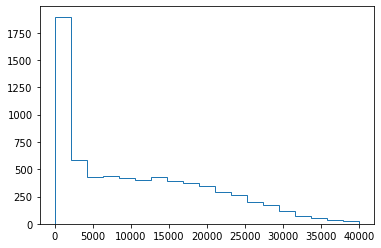

In [11]:
plt.hist(opt_cc_df[opt_cc_df.signal==0].score,histtype="step",bins=np.linspace(0,4e4,20))
# plt.hist(opt_cc_fail.truE,                   density=True,histtype="step",bins=np.linspace(0,5,20))
plt.show()

In [12]:
# the discrepancy of slice counts between opt_nc_df and opt_cc_df and opt_df is from events with more than one neutrino


# len(opt_df.index)-len(pd.concat([opt_cc_df,opt_nc_df]).index)

# test = pd.concat([opt_nc_df,opt_cc_df])
# plt.hist((opt_df.merge(test, how='left', indicator=True)
#      .query('_merge == "left_only"')
#      .drop('_merge', 1)).nnu)

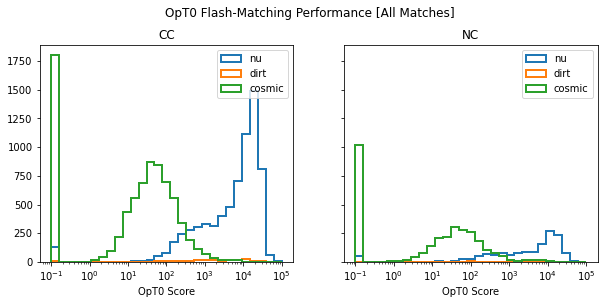

In [15]:
fig, axs = plt.subplots(1, 2,figsize=(10,4),sharey=True)
bins = np.logspace(-1,5,30)

for i in range(2):
    this_all = opt_cc_df if (i==0) else opt_nc_df 
    this_cut  = this_all.copy()
    color = [["mediumpurple","lightsalmon"],["rebeccapurple",'lightsalmon']]
    axs[i].hist([this_cut[this_cut.signal==0].drop_duplicates(subset=["run","subrun","event","pfpid"]).score],bins=bins,histtype="step",lw=2,label="nu")
    axs[i].hist([this_cut[this_cut.signal==1].drop_duplicates(subset=["run","subrun","event","pfpid"]).score],bins=bins,histtype="step",lw=2,label="dirt")
    axs[i].hist([this_cut[this_cut.signal==2].drop_duplicates(subset=["run","subrun","event","pfpid"]).score],bins=bins,histtype="step",lw=2,label="cosmic")
    axs[i].legend()
    
axs[0].ticklabel_format(axis='y', style='sci', scilimits=(-4,4))
axs[1].ticklabel_format(axis='y', style='sci', scilimits=(-4,4))
    
axs[0].set_title("CC")
axs[1].set_title("NC")

axs[0].set_xscale('log')
axs[1].set_xscale('log')

axs[1].set_xlabel("OpT0 Score")
axs[0].set_xlabel("OpT0 Score")
plt.suptitle("OpT0 Flash-Matching Performance [All Matches]",y=1.01)
plt.show()

In [19]:
# fig, axs = plt.subplots(1, 2,figsize=(10,4),sharey=True)
# bins = np.linspace(-1,40,30)

# for i in range(2):
#     this_all = sf_cc_df if (i==0) else sf_nc_df 
#     this_cut  = this_all.copy()
#     color = [["mediumpurple","lightsalmon"],["rebeccapurple",'lightsalmon']]
#     axs[i].hist([this_cut[this_cut.signal==0].fscore],bins=bins,histtype="step",lw=2,             color="navy", label="nu")
#     axs[i].hist([this_cut[this_cut.signal==1].fscore],bins=bins,histtype="step",lw=2, hatch="//", color="darkorange", label="dirt")
#     axs[i].hist([this_cut[this_cut.signal==2].fscore],bins=bins,histtype="step",lw=2, hatch="//", color="forestgreen", label="cosmic")
#     axs[i].legend()
    
# axs[0].ticklabel_format(axis='y', style='sci', scilimits=(-4,4))
# axs[1].ticklabel_format(axis='y', style='sci', scilimits=(-4,4))
    
# axs[0].set_title("CC")
# axs[1].set_title("NC")

# axs[0].set_xlabel("SimpleFlash Score")
# axs[1].set_xlabel("SimpleFlash Score")
# plt.suptitle("SimpleFlash Performance [All Matches]",y=1.01,fontsize=14)
# plt.show()

In [16]:
# fig, axs = plt.subplots(1, 2,figsize=(10,4),sharey=True)
# bins = np.linspace(-1,40,30)

# for i in range(2):
#     this_all = sf_old_cc_df if (i==0) else sf_old_nc_df 
#     this_cut  = this_all.copy()
#     color = [["mediumpurple","lightsalmon"],["rebeccapurple",'lightsalmon']]
#     axs[i].hist([this_cut[this_cut.signal==0].fscore],bins=bins,histtype="step",lw=2,             color="navy", label="nu")
#     axs[i].hist([this_cut[this_cut.signal==1].fscore],bins=bins,histtype="step",lw=2, hatch="//", color="darkorange", label="dirt")
#     axs[i].hist([this_cut[this_cut.signal==2].fscore],bins=bins,histtype="step",lw=2, hatch="//", color="forestgreen", label="cosmic")
#     axs[i].legend()
    
# axs[0].ticklabel_format(axis='y', style='sci', scilimits=(-4,4))
# axs[1].ticklabel_format(axis='y', style='sci', scilimits=(-4,4))
    
# axs[0].set_title("CC")
# axs[1].set_title("NC")

# axs[0].set_xlabel("SimpleFlash Score")
# axs[1].set_xlabel("SimpleFlash Score")
# plt.suptitle("(v09_37_00) SimpleFlash Performance [All Matches]",y=1.01,fontsize=14)
# plt.show()

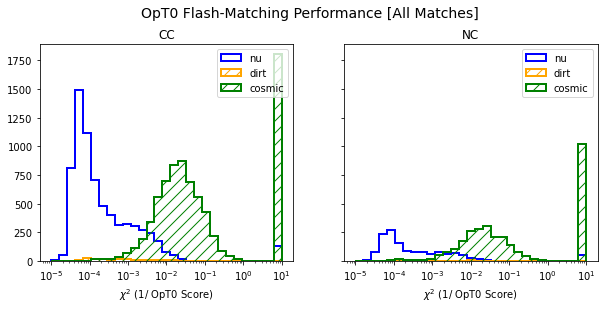

In [17]:
fig, axs = plt.subplots(1, 2,figsize=(10,4),sharey=True)
bins = np.logspace(-5,1,30)

for i in range(2):
    this_all = opt_cc_df if (i==0) else opt_nc_df 
    this_cut  = this_all.copy()
    # this_cut["score"] = np.where(this_cut.score < 0, 0.1, this_cut.score)
    color = [["mediumpurple","lightsalmon"],["rebeccapurple",'lightsalmon']]
    axs[i].hist([1/this_cut[this_cut.signal==0].score],bins=bins,histtype="step",lw=2,           color="blue",label="nu")
    axs[i].hist([1/this_cut[this_cut.signal==1].score],bins=bins,histtype="step",lw=2,hatch='//',color="orange",label="dirt")
    axs[i].hist([1/this_cut[this_cut.signal==2].score],bins=bins,histtype="step",lw=2,hatch='//',color="green",label="cosmic")
    axs[i].legend()
    
axs[0].ticklabel_format(axis='y', style='sci', scilimits=(-4,4))
axs[1].ticklabel_format(axis='y', style='sci', scilimits=(-4,4))
    
axs[0].set_title("CC")
axs[1].set_title("NC")

axs[0].set_xscale('log')
axs[1].set_xscale('log')

axs[0].set_xlabel("$\chi^2$ (1/ OpT0 Score)")
axs[1].set_xlabel("$\chi^2$ (1/ OpT0 Score)")
plt.suptitle("OpT0 Flash-Matching Performance [All Matches]",y=1.01,fontsize=14)
plt.show()

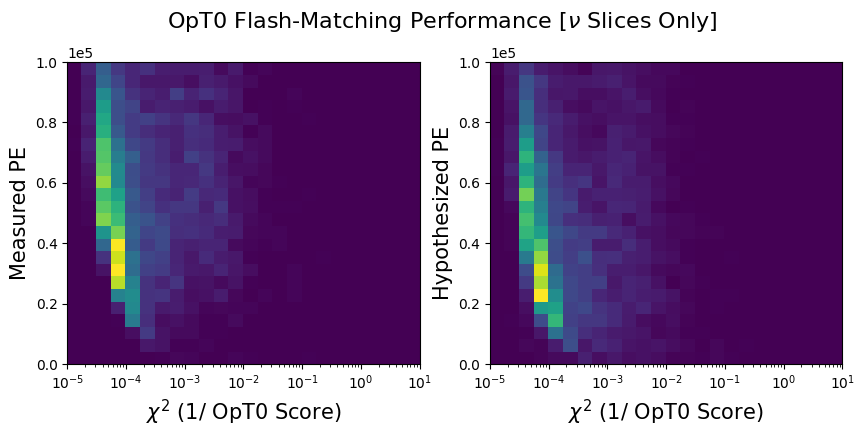

In [18]:
fig, axs = plt.subplots(1, 2,figsize=(10,4),dpi=100)
bins = np.logspace(-5,1,25)

this_all = pd.concat([opt_cc_df, opt_nc_df])
this_df  = this_all[(this_all.signal==0) & (this_all.flash_pe.isna()==False)]
axs[0].hist2d(1/this_df.score,
              this_df.flash_pe,
              bins=[bins,np.linspace(0,1e5,25)])
axs[0].set_xscale('log')
axs[0].set_ylabel("Measured PE",fontsize=15)
axs[0].ticklabel_format(axis='y', style='sci', scilimits=(-4,4))

this_all = pd.concat([opt_cc_df, opt_nc_df])
this_df  = this_all[(this_all.signal==0) & (this_all.flash_pe.isna()==False)]
axs[1].hist2d(1/this_df.score,
              this_df.hypo_pe,
              bins=[bins,np.linspace(0,1e5,25)])
axs[1].set_ylabel("Hypothesized PE",fontsize=15)
axs[1].set_xscale('log')
axs[1].ticklabel_format(axis='y', style='sci', scilimits=(-4,4))

axs[0].set_xlabel("$\chi^2$ (1/ OpT0 Score)",fontsize=15)
axs[1].set_xlabel("$\chi^2$ (1/ OpT0 Score)",fontsize=15)
plt.suptitle(r"OpT0 Flash-Matching Performance [$\nu$ Slices Only]",y=1.01,fontsize=16)
plt.show()

In [19]:
this_all = pd.concat([opt_cc_df, opt_nc_df])
this_df  = this_all[(this_all.signal==0) & (this_all.flash_pe.isna()==False)] 
this_df = this_df[this_df.score < 1e3]
missing_df = this_df.sort_values(by=["run","subrun"])[:200][["subrun","event","pfpid"]]

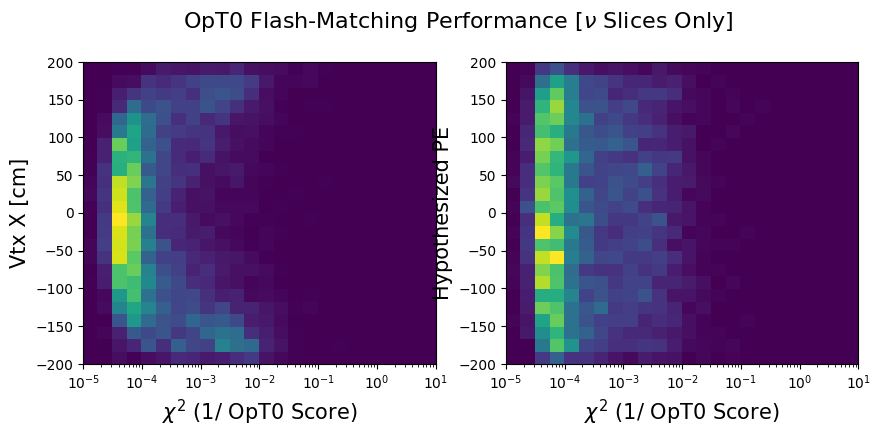

In [20]:
fig, axs = plt.subplots(1, 2,figsize=(10,4),dpi=100)
bins = np.logspace(-5,1,25)

this_all = pd.concat([opt_cc_df, opt_nc_df])
this_df  = this_all[(this_all.signal==0) & (this_all.flash_pe.isna()==False)]
axs[0].hist2d(1/this_df.score,
              this_df.vtx_x,
              bins=[bins,np.linspace(-200,200,25)])
axs[0].set_xscale('log')
axs[0].set_ylabel("Vtx X [cm]",fontsize=15)
# axs[0].ticklabel_format(axis='y', style='sci', scilimits=(-4,4))

this_all = pd.concat([opt_cc_df, opt_nc_df])
this_df  = this_all[(this_all.signal==0) & (this_all.flash_pe.isna()==False)]
axs[1].hist2d(1/this_df.score,
              this_df.vtx_y,
              bins=[bins,np.linspace(-200,200,25)])
axs[1].set_ylabel("Hypothesized PE",fontsize=15)
axs[1].set_xscale('log')
# axs[1].ticklabel_format(axis='y', style='sci', scilimits=(-4,4))

axs[0].set_xlabel("$\chi^2$ (1/ OpT0 Score)",fontsize=15)
axs[1].set_xlabel("$\chi^2$ (1/ OpT0 Score)",fontsize=15)
plt.suptitle(r"OpT0 Flash-Matching Performance [$\nu$ Slices Only]",y=1.01,fontsize=16)
plt.show()

In [21]:
print("number of slices attributed to cc events:", len(opt_df[(opt_df.signal<2) & (opt_df.iscc==1)].drop_duplicates(subset=["run","subrun","event","pfpid"]).index))
print("number of slices attributed to nc events:", len(opt_df[(opt_df.signal<2) & (opt_df.isnc==1)].drop_duplicates(subset=["run","subrun","event","pfpid"]).index))
print("number of cosmic slices: ", len(opt_df[opt_df.signal==2].index))

print("number of cc events:", len(opt_df[(opt_df.signal<2) & (opt_df.iscc==1)].drop_duplicates(subset=["run","subrun","event","nu_index"]).index))
print("number of nc events:", len(opt_df[(opt_df.signal<2) & (opt_df.isnc==1)].drop_duplicates(subset=["run","subrun","event","nu_index"]).index))

number of slices attributed to cc events: 7976
number of slices attributed to nc events: 1697
number of cosmic slices:  11343
number of cc events: 7729
number of nc events: 1604


In [23]:
cut_df = opt_df[(opt_df.score > 300)]
print ("cc (event) eff: ",   len(cut_df[(cut_df.match<2) & (cut_df.iscc==1)].drop_duplicates(subset=["run","subrun","event","nu_index"]).index)/len(opt_df[(opt_df.signal==0) & (opt_df.iscc==1)].drop_duplicates(subset=["run","subrun","event","nu_index"]).index))
print ("nc (event) eff: ",   len(cut_df[(cut_df.match<2) & (cut_df.isnc==1)].drop_duplicates(subset=["run","subrun","event","nu_index"]).index)/len(opt_df[(opt_df.signal==0) & (opt_df.isnc==1)].drop_duplicates(subset=["run","subrun","event","nu_index"]).index))
print ("% of cosmics remaining: ", len(cut_df[cut_df.signal==2].index)/len(opt_df[opt_df.signal==2].index))

cc (event) eff:  0.8951924357437742
nc (event) eff:  0.8362802881466929
% of cosmics remaining:  0.07158600017632019


In [24]:
Npts = 20
score_cut = np.logspace(1,4,Npts)
eff_cc = np.zeros(Npts); eff_nc = np.zeros(Npts); eff_mu = np.zeros(Npts)
pur_cc = np.zeros(Npts); pur_nc = np.zeros(Npts)
for i, cut in enumerate(score_cut):
    all_df = opt_df.copy()
    cut_df = all_df[all_df.score>cut]
    nall_cc = len(all_df[(all_df.match<2) & (all_df.iscc==1)].index)
    nall_nc = len(all_df[(all_df.match<2) & (all_df.isnc==1)].index)
    ncut_cc = len(cut_df[(cut_df.match<2) & (cut_df.iscc==1)].index)
    ncut_nc = len(cut_df[(cut_df.match<2) & (cut_df.isnc==1)].index)
    eff_cc[i] = ncut_cc/nall_cc
    eff_nc[i] = ncut_nc/nall_nc
    
    pur_cc[i] = len(opt_cc_df[(opt_cc_df.signal==0) & (opt_cc_df.score > cut)].drop_duplicates(subset=["run","subrun","event","pfpid"]).index)/len(opt_cc_df[(opt_cc_df.score > cut)].drop_duplicates(subset=["run","subrun","event","pfpid"]).index)
    pur_nc[i] = len(opt_nc_df[(opt_nc_df.signal==0) & (opt_nc_df.score > cut)].drop_duplicates(subset=["run","subrun","event","pfpid"]).index)/len(opt_nc_df[(opt_nc_df.score > cut)].drop_duplicates(subset=["run","subrun","event","pfpid"]).index)
    
    
sf_eff_cc = np.zeros(Npts); sf_eff_nc = np.zeros(Npts);
sf_pur_cc = np.zeros(Npts); sf_pur_nc = np.zeros(Npts)

sf_cut = np.linspace(5,20,Npts)
for i, cut in enumerate(sf_cut):
    all_df = pd.concat([sf_cc_df,sf_nc_df]).copy()
    cut_df = all_df[(all_df.fscore<cut) & (all_df.fscore>0)]
    nall_cc = len(all_df[(all_df.signal==0) & (all_df.iscc==1)].index)
    nall_nc = len(all_df[(all_df.signal==0) & (all_df.isnc==1)].index)
    nall_mu = len(all_df[all_df.signal==2].index)
    
    ncut_cc = len(cut_df[(cut_df.signal==0) & (cut_df.iscc==1)].index)
    ncut_nc = len(cut_df[(cut_df.signal==0) & (cut_df.isnc==1)].index)
    ncut_mu = len(cut_df[cut_df.signal==2].index)
    sf_eff_cc[i] = ncut_cc/nall_cc
    sf_eff_nc[i] = ncut_nc/nall_nc
    
    sf_pur_cc[i] = len(sf_cc_df[(sf_cc_df.signal==0) & (sf_cc_df.fscore < cut) & (sf_cc_df.fscore > 0)].drop_duplicates(subset=["run","subrun","event","pfpid"]).index)/len(sf_cc_df[(sf_cc_df.fscore < cut) & (sf_cc_df.fscore > 0)].drop_duplicates(subset=["run","subrun","event","pfpid"]).index)
    sf_pur_nc[i] = len(sf_nc_df[(sf_nc_df.signal==0) & (sf_nc_df.fscore < cut) & (sf_nc_df.fscore > 0)].drop_duplicates(subset=["run","subrun","event","pfpid"]).index)/len(sf_nc_df[(sf_nc_df.fscore < cut) & (sf_nc_df.fscore > 0)].drop_duplicates(subset=["run","subrun","event","pfpid"]).index)

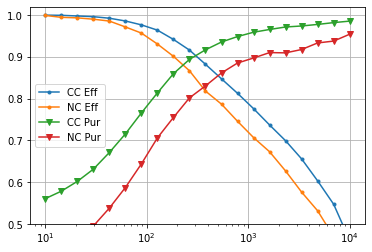

In [25]:
plt.plot(score_cut,eff_cc,".-",label="CC Eff")
plt.plot(score_cut,eff_nc,".-",label="NC Eff")
plt.plot(score_cut,pur_cc,'v-',label="CC Pur")
plt.plot(score_cut,pur_nc,'v-',label="NC Pur")
plt.xscale("log")
plt.legend()
plt.grid()
plt.ylim(0.5,1.02)
plt.show()

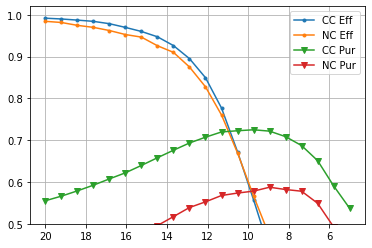

In [26]:
plt.plot(sf_cut,sf_eff_cc,".-",label="CC Eff")
plt.plot(sf_cut,sf_eff_nc,".-",label="NC Eff")
plt.plot(sf_cut,sf_pur_cc,'v-',label="CC Pur")
plt.plot(sf_cut,sf_pur_nc,'v-',label="NC Pur")
plt.grid()
plt.ylim(0.5,1.02)
left, right = plt.xlim()
plt.xlim(right,left)
plt.legend()
plt.show()

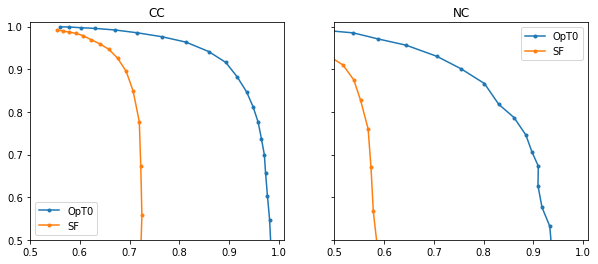

In [27]:
fig, axes = plt.subplots(1,2,figsize=(10,4),sharey=True,sharex=True)
axes[0].plot(pur_cc,eff_cc,".-",label="OpT0")
axes[0].plot(sf_pur_cc,sf_eff_cc,".-",label="SF")

axes[1].plot(pur_nc,eff_nc,".-",label="OpT0")
axes[1].plot(sf_pur_nc,sf_eff_nc,".-",label="SF")

axes[0].set_ylim(0.5,1.01)
axes[0].set_xlim(0.5,1.01)
axes[0].legend()
axes[1].legend()

axes[0].set_title("CC")
axes[1].set_title("NC")
plt.show()

# timing resolution

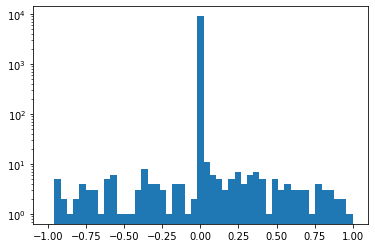

In [28]:
this_df = opt_df[opt_df.match < 2]

plt.hist(this_df.time-this_df.t0,bins=np.linspace(-1,1,50))
plt.ticklabel_format(axis='x', style='sci', scilimits=(-2,4))
plt.yscale('log')
plt.show()